<a href="https://colab.research.google.com/github/MizanMustakim/BIT_Machine_Learning_Course_Assignments_2022/blob/main/intelligent_transportation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split as tts
from xgboost import XGBRegressor
from sklearn.metrics import confusion_matrix

In [4]:
df1 = pd.read_csv(r"/content/drive/MyDrive/intelligent_transportation_project/gy_link_info.txt", delimiter=";")
df1

,link_ID,length,width,link_class
0,4377906289869500514,57,3,1
1,4377906284594800514,247,9,1
2,4377906289425800514,194,3,1
3,4377906284525800514,839,3,1
4,4377906284422600514,55,12,1
...,...,...,...,...
127,4377906288421600514,128,9,1
128,4377906289041600514,208,9,1
129,4377906286032600514,257,12,1
130,4377906281234600514,16,3,1


In [5]:
df2 = pd.read_csv("/content/drive/MyDrive/intelligent_transportation_project/gy_link_top.txt", delimiter=";")
df2.head()

,link_ID,in_links,out_links
0,4377906289869500514,4377906285525800514,4377906281969500514
1,4377906284594800514,4377906284514600514,4377906285594800514
2,4377906289425800514,NaN,4377906284653600514
3,4377906284525800514,4377906281234600514,4377906280334600514
4,4377906284422600514,3377906289434510514#4377906287959500514,4377906283422600514


In [ ]:
df2["in_links"] = df2["in_links"].fillna("0")
df2["out_links"] = df2["out_links"].fillna("0")
df2.head()

,link_ID,in_links,out_links
0,4377906289869500514,4377906285525800514,4377906281969500514
1,4377906284594800514,4377906284514600514,4377906285594800514
2,4377906289425800514,0,4377906284653600514
3,4377906284525800514,4377906281234600514,4377906280334600514
4,4377906284422600514,3377906289434510514#4377906287959500514,4377906283422600514


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   link_ID    132 non-null    uint64
 1   in_links   132 non-null    object
 2   out_links  132 non-null    object
dtypes: object(2), uint64(1)
memory usage: 3.2+ KB


In [18]:
df3 = pd.read_csv("/content/drive/MyDrive/intelligent_transportation_project/gy_link_travel_time_part2.txt", delimiter=";")
df3.head()

,linkID,date,time_interval,travel_time
0,4377906283422600514,2017-05-06,"[2017-05-06 11:04:00,2017-05-06 11:06:00)",3.0
1,3377906289434510514,2017-05-06,"[2017-05-06 10:42:00,2017-05-06 10:44:00)",1.0
2,3377906285934510514,2017-05-06,"[2017-05-06 11:56:00,2017-05-06 11:58:00)",35.2
3,3377906285934510514,2017-05-06,"[2017-05-06 17:46:00,2017-05-06 17:48:00)",26.2
4,3377906287934510514,2017-05-06,"[2017-05-06 10:52:00,2017-05-06 10:54:00)",10.4


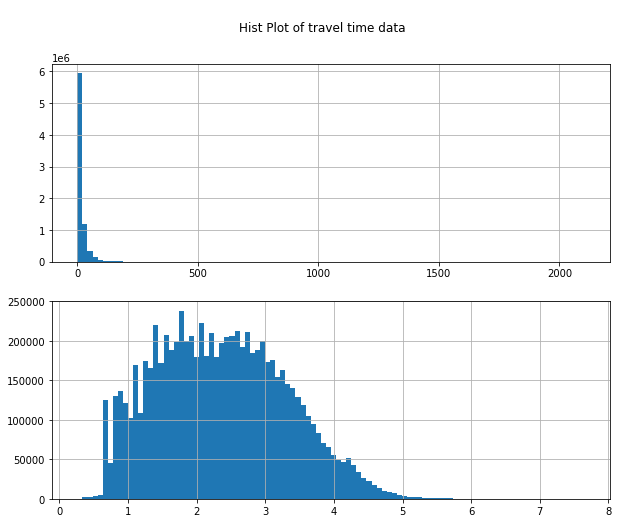

In [19]:
fig, axes = plt.subplots(figsize=(10,8), nrows=2, ncols=1)
fig.suptitle("\nHist Plot of travel time data\n")
df3["travel_time"].hist(bins=100, ax=axes[0])
df3["travel_time"] = np.log1p(df3["travel_time"])
df3["travel_time"].hist(bins=100, ax=axes[1])

plt.show()

In [ ]:
def quantile(data):
    data[data < data.quantile(0.05)] = data.quantile(0.05)
    data[data > data.quantile(0.95)] = data.quantile(0.95)

    return data

df3["travel_time"] = df3.groupby(["linkID", "date"])["travel_time"].transform(quantile)

In [ ]:
df3.shape

(7705175, 4)

In [ ]:
df3["date"] = pd.to_datetime(df3["date"])
df3["date"].describe()

count                 7705175
unique                    122
top       2017-05-05 00:00:00
freq                    89149
first     2017-03-01 00:00:00
last      2017-06-30 00:00:00
Name: date, dtype: object

In [ ]:
df3 = df3.loc[df3["date"] < "2017-03-8"].reset_index(drop=True)
df3.head()

,linkID,date,time_interval,travel_time
0,3377906285434510514,2017-03-04,"[2017-03-04 17:12:00,2017-03-04 17:14:00)",0.741937
1,3377906285934510514,2017-03-04,"[2017-03-04 03:42:00,2017-03-04 03:44:00)",2.097962
2,3377906287674510514,2017-03-04,"[2017-03-04 07:22:00,2017-03-04 07:24:00)",1.609438
3,3377906289674510514,2017-03-04,"[2017-03-04 06:40:00,2017-03-04 06:42:00)",1.648659
4,3377906284395510514,2017-03-04,"[2017-03-04 12:28:00,2017-03-04 12:30:00)",1.547563


In [ ]:
df3["Start_time"] = [i.strip("[)").split(",")[0].split(" ")[1] for i in df3["time_interval"]]
df3 = df3.drop(["time_interval"], axis=1)
df3.head()

,linkID,date,travel_time,Start_time
0,3377906285434510514,2017-03-04,0.741937,17:12:00
1,3377906285934510514,2017-03-04,2.097962,03:42:00
2,3377906287674510514,2017-03-04,1.609438,07:22:00
3,3377906289674510514,2017-03-04,1.648659,06:40:00
4,3377906284395510514,2017-03-04,1.547563,12:28:00


In [ ]:
# df3["Start_time"] = pd.to_datetime(df3["Start_time"]).dt.time
# df3["Start_time"].describe()

count      1100043
unique         720
top       18:38:00
freq          1799
Name: Start_time, dtype: object

##### Phase distribution of day

In [ ]:
empty_time_phase = np.zeros((df3.shape[0],720))
empty_time_phase_df = pd.DataFrame(empty_time_phase, columns = ["phase"+str(i+1) for i in range(720)])
df4 = pd.concat([df3, empty_time_phase_df], axis=1)

df4.head()

,linkID,date,travel_time,Start_time,phase1,phase2,phase3,phase4,phase5,phase6,...,phase711,phase712,phase713,phase714,phase715,phase716,phase717,phase718,phase719,phase720
0,3377906285434510514,2017-03-04,0.741937,17:12:00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3377906285934510514,2017-03-04,2.097962,03:42:00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3377906287674510514,2017-03-04,1.609438,07:22:00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3377906289674510514,2017-03-04,1.648659,06:40:00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3377906284395510514,2017-03-04,1.547563,12:28:00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df4.shape

(550863, 724)

In [ ]:
minute = list(range(0, 59, 2))
hour = list(range(0,24))
hour_phase = list(range(1,25))
minute_phase = list(range(1,31))
df4["day"] = np.zeros((df4.shape[0], 1))

for i in range(0,df4.shape[0]):
    a = hour.index(int(df4["Start_time"][i].split(":")[0]))
    b = minute.index(int(df4["Start_time"][i].split(":")[1]))
    phase_num = hour_phase[a] * minute_phase[b]
    column_name = "phase"+str(phase_num)
    df4[column_name][i] = 1

    if df4["date"][i].day % 7 != 0:
        df4["day"][i] = df4["date"][i].day % 7
    else:
        df4["day"][i] = 7

df4.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(550863, 725)

In [ ]:
df4 = df4.drop(["date"], axis=1)
df4.head()

,linkID,travel_time,Start_time,phase1,phase2,phase3,phase4,phase5,phase6,phase7,...,phase712,phase713,phase714,phase715,phase716,phase717,phase718,phase719,phase720,day
0,3377906285434510514,0.741937,17:12:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,3377906285934510514,2.097962,03:42:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,3377906287674510514,1.609438,07:22:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,3377906289674510514,1.648659,06:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
4,3377906284395510514,1.547563,12:28:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [ ]:
id = df1["link_ID"].unique()
index_data = pd.DataFrame(data=id, columns=["linkID"])
index_data["id_index"] = range(1, len(id)+1)
index_data.head()

,linkID,id_index
0,4377906289869500514,1
1,4377906284594800514,2
2,4377906289425800514,3
3,4377906284525800514,4
4,4377906284422600514,5


In [ ]:
final_data = pd.merge(df4,index_data, on="linkID", how="inner")
final_data.head()

,linkID,travel_time,Start_time,phase1,phase2,phase3,phase4,phase5,phase6,phase7,...,phase713,phase714,phase715,phase716,phase717,phase718,phase719,phase720,day,id_index
0,3377906285434510514,0.741937,17:12:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,119
1,3377906285434510514,0.955511,20:04:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,119
2,3377906285434510514,0.832909,11:56:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,119
3,3377906285434510514,0.832909,12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,119
4,3377906285434510514,1.098612,19:22:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,119


In [23]:
date = final_data["day"].values.tolist()
id = final_data["id_index"].values.tolist()
time_travel = final_data["travel_time"].values.tolist()
time = []
for i in final_data["Start_time"]:
    hour = i.split(":")[0]
    minute = i.split(":")[1]
    time.append((int(hour) * 60) + int(minute))

data = {"road_id":id,
        "day":date,
        "time(minute)":time,
        "travel_time":time_travel
        }

d = pd.DataFrame(data=data)
d

,road_id,day,time(minute),travel_time
0,119,4.0,1032,0.741937
1,119,4.0,1204,0.955511
2,119,4.0,716,0.832909
3,119,4.0,720,0.832909
4,119,4.0,1162,1.098612
...,...,...,...,...
550858,67,2.0,1188,2.476538
550859,67,2.0,1246,2.370244
550860,67,2.0,1282,3.520461
550861,67,2.0,1392,2.302585


In [24]:
X = d.drop(["travel_time"], axis=1)
Y = d["travel_time"]

X_train, X_test, y_train, y_test = tts(X, Y, test_size=0.20, shuffle=True)
print("Shape of input value for the train: ", X_train.shape[0])
print("Shape of input value for the test: ", X_test.shape[0])

print("\nShape of output value for the train: ", y_train.shape[0])
print("Shape of output value for the test: ", y_test.shape[0])

Shape of input value for the train:  440690
Shape of input value for the test:  110173

Shape of output value for the train:  440690
Shape of output value for the test:  110173


In [ ]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550863 entries, 0 to 550862
Columns: 725 entries, linkID to id_index
dtypes: float64(722), int64(1), object(1), uint64(1)
memory usage: 3.0+ GB


In [ ]:
final_data.to_csv("/content/drive/MyDrive/final_data.csv", index=False)

In [22]:
final_data = pd.read_csv("/content/drive/MyDrive/final_data.csv")

In [ ]:
X = final_data.drop(["linkID", "Start_time", "travel_time"], axis=1)
Y = final_data[["travel_time"]]

X_train, X_test, y_train, y_test = tts(X, Y, test_size=0.40, shuffle=True)
print("Shape of input value for the train: ", X_train.shape[0])
print("Shape of input value for the test: ", X_test.shape[0])

print("\nShape of output value for the train: ", y_train.shape[0])
print("Shape of output value for the test: ", y_test.shape[0])

Shape of input value for the train:  330517
Shape of input value for the test:  220346

Shape of output value for the train:  330517
Shape of output value for the test:  220346


In [ ]:
model = tf.keras.models.Sequential([tf.keras.layers.Dense(64, activation="relu", input_shape=[X_train.shape[1]]),
                                    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                256       
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = tf.keras.optimizers.RMSprop(learning_rate=0.00001)
model.compile(
    loss='mse',
    optimizer = opt)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                               min_delta=0,
                               patience=2,
                               verbose=0, mode='auto')

            
epoch = 100
batch_size = X_train.shape[0] // epoch

# Train the Model
history = model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping])

model.save("/content/drive/MyDrive/intelligent_transportation_project/model.h5")


Epoch 1/100
101/101 [==============================] - 1s 4ms/step - loss: 4062.5718 - val_loss: 3531.2976
Epoch 2/100
101/101 [==============================] - 0s 3ms/step - loss: 3082.4988 - val_loss: 2631.1626
Epoch 3/100
101/101 [==============================] - 0s 3ms/step - loss: 2246.8022 - val_loss: 1864.4674
Epoch 4/100
101/101 [==============================] - 0s 3ms/step - loss: 1546.8420 - val_loss: 1236.4595
Epoch 5/100
101/101 [==============================] - 0s 3ms/step - loss: 982.1786 - val_loss: 739.8640
Epoch 6/100
101/101 [==============================] - 0s 3ms/step - loss: 553.2123 - val_loss: 381.6969
Epoch 7/100
101/101 [==============================] - 0s 3ms/step - loss: 258.5881 - val_loss: 154.1552
Epoch 8/100
101/101 [==============================] - 0s 3ms/step - loss: 94.9574 - val_loss: 55.2715
Epoch 9/100
101/101 [==============================] - 0s 3ms/step - loss: 46.6320 - val_loss: 43.3671
Epoch 10/100
101/101 [=============================

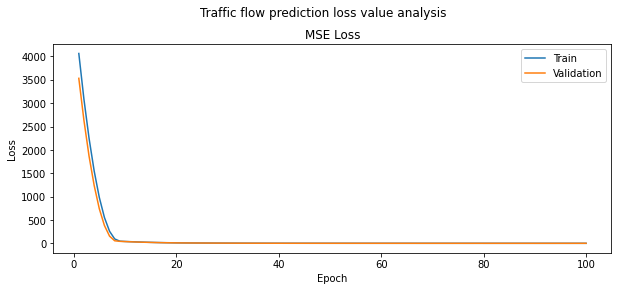

In [ ]:
f, ax1 = plt.subplots(1, 1, figsize=(10, 4))
t = f.suptitle('Traffic flow prediction loss value analysis', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = range(1, len(history.history["loss"])+1)

ax1.plot(epochs, history.history['loss'], label='Train')
ax1.plot(epochs, history.history['val_loss'], label='Validation')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.set_title('MSE Loss')
l1 = ax1.legend(loc="best")

In [25]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [ ]:
model2 = XGBRegressor().fit(X_train, y_train)
y_pred = model2.predict(X_test).reshape(-1,1)
model2.save_model("/content/drive/MyDrive/XGBRegressor_modedl.h5")

[14:32:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [26]:
model2 = XGBRegressor()
model2.load_model("/content/drive/MyDrive/XGBRegressor_modedl.h5")
y_pred = model2.predict(X_test).reshape(-1,1)

[14:50:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
a = MAPE(y_test, y_pred)[0]

In [ ]:
b = MAPE(y_test, model.predict(X_test))

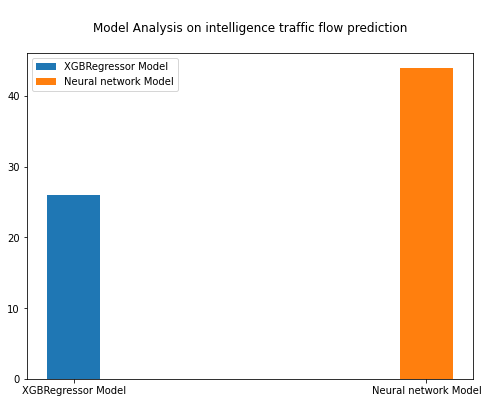

In [ ]:
plt.figure(figsize=(8,6))
plt.bar("XGBRegressor Model",a, label="XGBRegressor Model", width=0.15)
plt.bar("Neural network Model",b, label="Neural network Model", width=0.15)
plt.title("\nModel Analysis on intelligence traffic flow prediction\n")
plt.legend()
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

6886/6886 [==============================] - 13s 2ms/step - loss: 0.8584 - accuracy: 0.0000e+00


[0.8584083914756775, 0.0]

In [ ]:
model2.score(X_test, y_test)

In [ ]:
cleaned_data = index_data.copy()
cleaned_data.head()

,link_id,id_index
0,4377906289869500514,1
1,4377906284594800514,2
2,4377906289425800514,3
3,4377906284525800514,4
4,4377906284422600514,5


In [ ]:
x = np.zeros((132,132))
empty_df = pd.DataFrame(x, columns=list(range(1, x.shape[0]+1)))
cleaned_data = pd.concat([index_data, empty_df], axis=1)

In [ ]:
for i in range(cleaned_data.shape[0]):
    if "#" in df2["in_links"][i]:
        a = df2["in_links"][i].split("#")
        for j in a:
            column_id = cleaned_data["id_index"][cleaned_data["link_id"] == eval(j)].values[0]
            row_index = cleaned_data["link_id"][cleaned_data["link_id"] == int(df2["link_ID"][i])].index[0]
            cleaned_data.loc[row_index, column_id] = 1  
    elif eval(df2["in_links"][i]) != 0:
        column_id = cleaned_data["id_index"][cleaned_data["link_id"] == eval(df2["in_links"][i])].values[0]     #column_id
        row_index = cleaned_data["link_id"][cleaned_data["link_id"] == int(df2["link_ID"][i])].index[0]         # row index
        cleaned_data.loc[row_index, column_id] = 1

    else:
        pass

In [ ]:
for i in range(cleaned_data.shape[0]):
    if "#" in df2["out_links"][i]:
        a = df2["out_links"][i].split("#")
        for j in a:
            column_id = cleaned_data["id_index"][cleaned_data["link_id"] == eval(j)].values[0]
            row_index = cleaned_data["link_id"][cleaned_data["link_id"] == int(df2["link_ID"][i])].index[0]
            cleaned_data.loc[row_index, column_id] = -1  
    elif eval(df2["out_links"][i]) != 0:
        column_id = cleaned_data["id_index"][cleaned_data["link_id"] == eval(df2["out_links"][i])].values[0]     #column_id
        row_index = cleaned_data["link_id"][cleaned_data["link_id"] == int(df2["link_ID"][i])].index[0]         # row index
        cleaned_data.loc[row_index, column_id] = -1

    else:
        pass

In [ ]:
cleaned_data.head()

,link_id,id_index
0,4377906289869500514,1
1,4377906284594800514,2
2,4377906289425800514,3
3,4377906284525800514,4
4,4377906284422600514,5


In [ ]:
cleaned_data.to_csv("/content/drive/MyDrive/intelligent_transportation_project/clean.csv")

In [ ]:
df2.loc[df2["link_ID"] == cleaned_data["link_id"][92]]

,link_ID,in_links,out_links
92,3377906282418510514,4377906280329500514#4377906286334600514,4377906281784800514


In [ ]:
cleaned_data.loc[cleaned_data["link_id"] == 4377906280329500514]

,link_id,id_index,1,2,3,4,5,6,7,8,...,123,124,125,126,127,128,129,130,131,132
54,4377906280329500514,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
cleaned_data["link_id"][cleaned_data["link_id"] == int(df2["link_ID"][0])].index[0]

0

In [ ]:
cleaned_data.rename(columns={"link_id":"linkID"}, inplace=True)
cleaned_data

,linkID,id_index,1,2,3,4,5,6,7,8,...,123,124,125,126,127,128,129,130,131,132
0,4377906289869500514,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4377906284594800514,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4377906289425800514,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4377906284525800514,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4377906284422600514,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,4377906288421600514,128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
128,4377906289041600514,129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129,4377906286032600514,130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130,4377906281234600514,131,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Columns: 134 entries, linkID to 132
dtypes: float64(132), int64(1), uint64(1)
memory usage: 138.3 KB


In [ ]:
data = df3[["linkID", "date", "Start_time", "travel_time"]]


In [ ]:
int(data["time_interval"][0].strip("[)").split(",")[0].split(" ")[0].split("-")[-1])

6

In [ ]:
int(data["time_interval"][0].strip("[)").split(",")[0].split(" ")[1].split(":")[1])

4

In [ ]:
day = [int(i.strip("[)").split(",")[0].split(" ")[0].split("-")[-1]) for i in df3["time_interval"]]
start_hour = [int(i.strip("[)").split(",")[0].split(" ")[1].split(":")[0]) for i in df3["time_interval"]]
start_minute = [int(i.strip("[)").split(",")[0].split(" ")[1].split(":")[1]) for i in df3["time_interval"]]
month = [int(i.strip("[)").split(",")[0].split(" ")[0].split("-")[1]) for i in df3["time_interval"]]

In [ ]:
data["month"] = month
data["day"] = day

data["hour"] = start_hour
data["Start_minute"] = start_minute

data.head()

,linkID,travel_time,month,day,hour,Start_minute
0,4377906283422600514,3.0,5,6,11,4
1,3377906289434510514,1.0,5,6,10,42
2,3377906285934510514,35.2,5,6,11,56
3,3377906285934510514,26.2,5,6,17,46
4,3377906287934510514,10.4,5,6,10,52


In [ ]:
end_minute = []
for i in df3["time_interval"]:
    a = int(i.strip("[)").split(",")[1].split(" ")[1].split(":")[1])
    if a == 0:
        end_minute.append(60)
    else:
        end_minute.append(a)

In [ ]:
data["End_minute"] = end_minute

data.head()

,linkID,travel_time,month,day,hour,Start_minute,End_minute
0,4377906283422600514,3.0,5,6,11,4,6
1,3377906289434510514,1.0,5,6,10,42,44
2,3377906285934510514,35.2,5,6,11,56,58
3,3377906285934510514,26.2,5,6,17,46,48
4,3377906287934510514,10.4,5,6,10,52,54


In [ ]:
data.tail(10)

,linkID,date,Start_time,travel_time
7512339,9377906283125510514,2017-03-02,15:36:00,24.0
7512340,9377906283125510514,2017-03-02,15:38:00,15.4
7512341,9377906283125510514,2017-03-02,16:20:00,17.5
7512342,9377906283125510514,2017-03-02,16:42:00,16.3
7512343,9377906283125510514,2017-03-02,19:40:00,15.8
7512344,3377906285934510514,2017-03-02,02:56:00,22.3
7512345,3377906285934510514,2017-03-02,04:38:00,36.9
7512346,3377906285934510514,2017-03-02,05:10:00,8.0
7512347,3377906285934510514,2017-03-02,05:16:00,8.0
7512348,3377906285934510514,2017-03-02,08:00:00,11.1


In [ ]:
data.shape

(7705175, 7)

In [ ]:
train_data = pd.merge(data, cleaned_data, how="inner", on="linkID")

train_data.head()

,linkID,date,Start_time,travel_time,id_index,1,2,3,4,5,...,123,124,125,126,127,128,129,130,131,132
0,9377906282776510514,2017-03-27,05:44:00,1.3,90,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9377906282776510514,2017-03-27,02:06:00,3.2,90,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9377906282776510514,2017-03-27,19:00:00,1.8,90,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9377906282776510514,2017-03-27,09:38:00,1.3,90,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9377906282776510514,2017-03-27,04:22:00,1.0,90,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X = train_data[["month", "day", "hour", "Start_minute", "End_minute", "id_index"]]
Y = train_data[["travel_time"]]

In [ ]:
train_data.to_csv("/content/drive/MyDrive/intelligent_transportation_project/train.csv", index=False)

In [ ]:
train = train_data[::10]
validation = train_data[::50]
test = train_data[10::50]

In [ ]:
train.to_csv("/content/drive/MyDrive/intelligent_transportation_project/train_data.csv", index=False)

In [ ]:
validation.to_csv("/content/drive/MyDrive/intelligent_transportation_project/validation_data.csv", index=False)

In [ ]:
test.to_csv("/content/drive/MyDrive/intelligent_transportation_project/test_data.csv", index=False)

In [ ]:
X_train = train.drop(["linkID", "travel_time", "id_index"], axis=1)
y_train = train[["travel_time"]]

In [ ]:
X_validation = validation.drop(["linkID", "travel_time", "id_index"], axis=1)
y_validation = validation[["travel_time"]]

In [ ]:
X_test = test.drop(["linkID", "travel_time", "id_index"], axis=1)
y_test = test[["travel_time"]]

In [ ]:
# X_train, X_test, y_train, y_test = tts(X, Y, test_size=0.20, shuffle=True)
print("Shape of input value for the train: ", X_train.shape[0])
print("Shape of input value for the test: ", X_test.shape[0])
print("Shape of input value for the validation: ", X_validation.shape[0])

print("\nShape of output value for the train: ", y_train.shape[0])
print("Shape of output value for the test: ", y_test.shape[0])
print("Shape of output value for the train: ", y_validation.shape[0])

Shape of input value for the train:  247566
Shape of input value for the test:  49513
Shape of input value for the validation:  49514

Shape of output value for the train:  247566
Shape of output value for the test:  49513
Shape of output value for the train:  49514


In [ ]:
X_train.shape, y_train.shape

((247566, 134), (247566, 1))

In [ ]:
X_train.shape

(3852585, 137)

In [ ]:
a = train_data[:3852585]
1926295, 1926295
a.shape

(13, 4)

In [ ]:
b = df1.drop(df1.index[3::10], axis=0)
b.shape

(119, 4)

In [ ]:
final_data["start_time"] = np.zeros((final_data.shape[0],1))
final_data["end_time"] = np.zeros((final_data.shape[0],1))
for i in range(final_data.shape[0]):

    final_data["start_time"][i] = time.mktime(datetime.datetime.strptime(final_data["time_interval"][i].strip("[)").split(",")[0], '%Y-%m-%d %H:%M:%S').timetuple())
    final_data["end_time"][i] = time.mktime(datetime.datetime.strptime(final_data["time_interval"][i].strip("[)").split(",")[1], '%Y-%m-%d %H:%M:%S').timetuple())

final_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,linkID,date,time_interval,travel_time,id_index,1,2,3,4,5,...,125,126,127,128,129,130,131,132,start_time,end_time
0,4377906283422600514,2017-05-06,"[2017-05-06 11:04:00,2017-05-06 11:06:00)",3.0,19,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.494069e+09,1.494069e+09
1,4377906283422600514,2017-05-06,"[2017-05-06 17:58:00,2017-05-06 18:00:00)",5.0,19,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.494093e+09,1.494094e+09
2,4377906283422600514,2017-05-06,"[2017-05-06 14:10:00,2017-05-06 14:12:00)",6.8,19,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.494080e+09,1.494080e+09
3,4377906283422600514,2017-05-06,"[2017-05-06 09:52:00,2017-05-06 09:54:00)",1.7,19,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.494064e+09,1.494064e+09
4,4377906283422600514,2017-05-06,"[2017-05-06 10:42:00,2017-05-06 10:44:00)",2.3,19,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.494067e+09,1.494067e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7705170,9377906286615510514,2017-06-29,"[2017-06-29 06:48:00,2017-06-29 06:50:00)",8.0,123,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.498719e+09,1.498719e+09
7705171,9377906286615510514,2017-06-29,"[2017-06-29 07:48:00,2017-06-29 07:50:00)",13.5,123,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.498722e+09,1.498723e+09
7705172,9377906286615510514,2017-06-11,"[2017-06-11 07:40:00,2017-06-11 07:42:00)",4.8,123,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.497167e+09,1.497167e+09
7705173,9377906286615510514,2017-06-11,"[2017-06-11 07:36:00,2017-06-11 07:38:00)",4.8,123,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.497167e+09,1.497167e+09


In [ ]:
final_data.to_csv("/content/drive/MyDrive/intelligent_transportation_project/final_data.csv", index=False)

In [ ]:
time.mktime(datetime.datetime.strptime(final_data["start_interval"][0], '%Y-%m-%d %H:%M:%S').timetuple())



1494068640.0